In [1]:
# Janky xgboost fix
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import pandas as pd
import numpy as np
import re
import os.path
import xgboost as xgb
import imblearn.over_sampling
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

from code.lw_pickle import var_to_pickle, read_pickle

%matplotlib inline

### Load Data

In [5]:
order_path = '../data/subset/'
common_path = '../data/common/'

In [6]:
orders_df = pd.read_csv(os.path.join(order_path, 'orders.csv'))
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1363380,50,prior,1,3,9,NaN
1,3131103,50,prior,2,6,12,10.0
2,2197066,50,prior,3,1,13,9.0
3,3201640,50,prior,4,0,11,6.0
4,2756806,50,prior,5,4,14,11.0


In [7]:
orders_prior_df = pd.read_csv(os.path.join(order_path, 'order_products__prior.csv'))
orders_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,12,30597,1,1
1,12,15221,2,1
2,12,43772,3,1
3,12,37886,4,1
4,12,37215,5,0


In [8]:
orders_train_df = pd.read_csv(os.path.join(order_path, 'order_products__train.csv'))
orders_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1077,13176,1,1
1,1077,39922,2,1
2,1077,5258,3,1
3,1077,21137,4,1
4,1119,6046,1,1


In [9]:
depts_df = pd.read_csv(os.path.join(common_path, 'departments.csv'))
depts_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [10]:
aisles_df = pd.read_csv(os.path.join(common_path, 'aisles.csv'))
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [11]:
products_df = pd.read_csv(os.path.join(common_path, 'products.csv'))
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


### Merge Product Dataframes

In [12]:
products_df = products_df.merge(aisles_df, how='left', on='aisle_id')
products_df = products_df.merge(depts_df, how='left', on='department_id')
products_df.drop(['aisle_id', 'department_id'], axis=1, inplace=True)
products_df.head()

,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,2,All-Seasons Salt,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen meals,frozen
4,5,Green Chile Anytime Sauce,marinades meat preparation,pantry


In [13]:
orders_prior_df = orders_prior_df.merge(orders_df.drop('eval_set', axis=1), on='order_id')
orders_train_df = orders_train_df.merge(orders_df.drop('eval_set', axis=1), on='order_id')
orders_train_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1077,13176,1,1,173934,11,6,9,10.0
1,1077,39922,2,1,173934,11,6,9,10.0
2,1077,5258,3,1,173934,11,6,9,10.0
3,1077,21137,4,1,173934,11,6,9,10.0
4,1119,6046,1,1,129386,7,1,14,17.0


### Merge Cart-level DataFrame

In [14]:
user_product_prior_df = (orders_prior_df.groupby(['product_id', 'user_id'], as_index=False)
                                        .agg({'order_id':'nunique',
                                              #'add_to_cart_order':'mean',
                                              #'order_dow':'mean',
                                              #'order_hour_of_day':'mean'
                                             })
                                        .rename(columns={'order_id':'count_in_user_orders',
                                                         #'add_to_cart_order':'prior_cart_add_order',
                                                         #'order_dow':'prior_order_dow',
                                                         #'order_hour_of_day':'prior_order_hour'
                                                        }))

train_users = orders_train_df['user_id'].unique()
user_product_df = user_product_prior_df[user_product_prior_df['user_id'].isin(train_users)]
user_product_df.reset_index(drop=True, inplace=True)

### Feature Engineering

#### Feature: Product Order Rate by User

In [15]:
orders_prior_per_user_df = orders_prior_df.groupby(['user_id'])[['order_id']].nunique()
orders_prior_per_user_df.rename(columns={'order_id':'total_user_orders'}, inplace=True)
user_product_df = user_product_prior_df.merge(orders_prior_per_user_df, on='user_id')
user_product_df['percent_in_user_orders'] = (user_product_df['count_in_user_orders'] /
                                             user_product_df['total_user_orders'])
user_product_df.drop(['count_in_user_orders'], axis=1, inplace=True)
#user_product_df.head()

#### Target: Whether or Not Product is in Cart

In [16]:
train_carts = (orders_train_df.groupby('user_id')
                              .agg({'product_id':(lambda x: set(x)),
                                    #'order_dow':'first',
                                    #'order_hour_of_day':'first',
                                   })
                              .rename(columns={'product_id':'cart_contents',
                                               #'order_hour_of_day':'order_hour'
                                              }))

user_product_df = user_product_df.merge(train_carts, on='user_id')
user_product_df['in_cart'] =\
    (user_product_df.apply(lambda row: row['product_id'] in row['cart_contents'], axis=1)
                    .astype(int))
user_product_df.drop('cart_contents', axis=1, inplace=True)

#user_product_df.head()

#### Feature: Product Overall Order Rate

In [17]:
product_prior_df = (orders_prior_df.groupby(['product_id'], as_index=False)
                                   .agg({'order_id':'nunique'})
                                   .rename(columns={'order_id':'count_in_all_orders'})
                                   .sort_values(by=['count_in_all_orders'], ascending=False)
                                   .reset_index(drop=True))
num_orders = orders_prior_df['order_id'].nunique()
product_prior_df['percent_in_all_orders'] = product_prior_df['count_in_all_orders'] / num_orders
product_prior_df.drop('count_in_all_orders', axis=1, inplace=True)
user_product_df = user_product_df.merge(product_prior_df, on='product_id')

#### Feature: Absolute Difference in Order Time
*Deactivated because features are not useful predictors*

user_product_df['order_dow_diff'] = np.abs(user_product_df['prior_order_dow'] -
                                           user_product_df['order_dow'])
user_product_df['order_hour_diff'] = np.abs(user_product_df['prior_order_hour'] -
                                           user_product_df['order_hour'])

#### Feature: In Last Cart

In [18]:
mask = (orders_prior_df.sort_values(by='order_number')
                       .groupby(['user_id'])['order_id']
                       .last())
last_cart_contents_df = (orders_prior_df[orders_prior_df['order_id'].isin(mask)]
                    .groupby(['user_id'])['product_id'].unique())
last_cart_contents_df = pd.DataFrame(last_cart_contents_df)
last_cart_contents_df.rename(columns={'product_id':'last_cart_contents'}, inplace=True)

user_product_df = user_product_df.merge(last_cart_contents_df, how='left', on='user_id')
user_product_df['in_last_cart'] =\
    (user_product_df.apply(lambda row: row['product_id'] in row['last_cart_contents'], axis=1)
                    .astype(int))
user_product_df.drop('last_cart_contents', axis=1, inplace=True)

#### Feature: Days/Orders Between Orders, Times Product Appears in Last 5 Orders

In [19]:
prior_order_nums_df = (orders_prior_df.groupby(['user_id', 'order_id'], as_index=False)
                                      .agg({'order_number':'first',
                                            'days_since_prior_order':'first'}))
prior_order_nums_df = (prior_order_nums_df.drop('days_since_prior_order', axis=1)
                                          .merge(prior_order_nums_df.drop('order_id', axis=1),
                                                                          how='left',
                                                                          on='user_id'))

mask = prior_order_nums_df['order_number_x'] <= prior_order_nums_df['order_number_y']
days_since_newest_df = prior_order_nums_df[mask].drop(['user_id', 'order_number_y'], axis=1)
days_since_newest_df = (days_since_newest_df.groupby(['order_id', 'order_number_x'],
                                                     as_index=False)['days_since_prior_order']
                                                     .sum())
days_since_newest_df.drop('order_number_x', axis=1, inplace=True)
days_since_newest_df.rename(columns={'days_since_prior_order':'days_since_newest'},
                            inplace=True)

mask = prior_order_nums_df['order_number_x'] >= prior_order_nums_df['order_number_y']
prior_order_nums_df = prior_order_nums_df[mask].drop(['user_id', 'order_number_y'], axis=1)
prior_order_nums_df = (prior_order_nums_df.groupby(['order_id', 'order_number_x'],
                                                   as_index=False)['days_since_prior_order']
                                                   .sum())
prior_order_nums_df.rename(columns={'days_since_prior_order':'days_since_first_order',
                                    'order_number_x':'order_number'}, inplace=True)

newest_cart_df = (orders_train_df.groupby(['user_id'])[['order_number', 'days_since_prior_order']]
                                 .first()
                                 .rename(columns={'order_number':'newest_order_number'}))

In [20]:
product_prior_since_df = orders_prior_df[['user_id', 'order_id', 'product_id']]
product_prior_since_df = product_prior_since_df.merge(prior_order_nums_df,
                                                      how='left',
                                                      on='order_id')
product_prior_since_df = product_prior_since_df.merge(days_since_newest_df,
                                                      how='left',
                                                      on='order_id')
product_prior_since_df = product_prior_since_df.merge(newest_cart_df,
                                                      how='left',
                                                      on='user_id')

product_prior_since_df['days_since_newest'] += product_prior_since_df['days_since_prior_order']
product_prior_since_df['orders_since_newest'] = (product_prior_since_df['newest_order_number'] -
                                                 product_prior_since_df['order_number'])
mask = (product_prior_since_df['order_number'] >=
        (product_prior_since_df['newest_order_number'] - 5))
in_last_five_df = (product_prior_since_df[mask].groupby(['user_id', 'product_id'],
                                                        as_index=False)['order_id']
                                               .count()
                                               .rename(columns={'order_id':'in_last_five'}))
product_prior_since_df = product_prior_since_df.merge(in_last_five_df,
                                                      how='left',
                                                      on=['user_id', 'product_id'])
product_prior_since_df['in_last_five'] = (product_prior_since_df['in_last_five'].fillna(0)
                                                                                .astype(int))

In [21]:
product_prior_since_df.sort_values(by=['user_id', 'product_id', 'order_number'], inplace=True)
product_prior_since_df.reset_index(drop=True, inplace=True)

product_prior_since_df['last_order_number'] =\
    product_prior_since_df.groupby(['user_id', 'product_id'])['order_number'].shift(1)
product_prior_since_df['last_days_since_first_order'] =\
    product_prior_since_df.groupby(['user_id', 'product_id'])['days_since_first_order'].shift(1)
product_prior_since_df['mean_orders_between'] = (product_prior_since_df['order_number'] -
                                               product_prior_since_df['last_order_number'])
product_prior_since_df['mean_days_between'] = (product_prior_since_df['days_since_first_order'] -
                                             product_prior_since_df['last_days_since_first_order'])

(product_prior_since_df['mean_orders_between'].fillna(product_prior_since_df['orders_since_newest'],
                                                      inplace=True))
(product_prior_since_df['mean_days_between'].fillna(product_prior_since_df['days_since_newest'],
                                                    inplace=True))

product_prior_since_df = (product_prior_since_df.groupby(['user_id', 'product_id'], as_index=False)
                                                .agg({'mean_orders_between':'mean',
                                                      'mean_days_between':'mean',
                                                      'orders_since_newest':'last',
                                                      'days_since_newest':'last',
                                                      'in_last_five':'last'}))
product_prior_since_df.rename({'order_number':'lastest_order_number'}, inplace=True)

product_prior_since_df['expected_order'] = (product_prior_since_df['orders_since_newest'] /
                                            product_prior_since_df['mean_orders_between'])

In [22]:
user_product_df = user_product_df.merge(product_prior_since_df,
                                        how='left',
                                        on=['user_id', 'product_id'])

#### Feature: Likelihood a Product Gets Reordered

In [23]:
product_proba_df = (orders_prior_df.groupby('product_id', as_index=False)
                                   .agg({'user_id':'nunique', 'order_id':'count'}))
product_proba_df['product_reorder_proba'] = 1 - (product_proba_df['user_id'] /
                                                 product_proba_df['order_id'])
product_proba_df.drop(['user_id', 'order_id'], axis=1, inplace=True)
user_product_df = user_product_df.merge(product_proba_df, how='left', on='product_id')

#### Feature: Likelihood a User Reorders Any Product

In [24]:
user_proba_df = (orders_prior_df.groupby('user_id', as_index=False)
                                .agg({'product_id':'nunique', 'order_id':'count'}))
user_proba_df['user_reorder_proba'] = 1 - (user_proba_df['product_id'] /
                                           user_proba_df['order_id'])
user_proba_df.drop(['product_id', 'order_id'], axis=1, inplace=True)
user_product_df = user_product_df.merge(user_proba_df, how='left', on='user_id')

#### Check All Features

In [25]:
user_product_df.sample(10)

,product_id,user_id,total_user_orders,percent_in_user_orders,in_cart,percent_in_all_orders,in_last_cart,mean_orders_between,mean_days_between,orders_since_newest,days_since_newest,in_last_five,expected_order,product_reorder_proba,user_reorder_proba
180874,45535,16832,43,0.069767,0,0.005806,0,11.000000,86.333333,27,228.0,0,2.454545,0.463415,0.648180
181647,5134,138636,61,0.016393,0,0.003785,0,16.000000,118.000000,16,118.0,0,1.000000,0.557823,0.660819
263493,34164,30630,21,0.047619,0,0.000051,0,3.000000,97.000000,3,97.0,1,1.000000,0.000000,0.605341
312853,17935,63098,14,0.071429,0,0.000013,0,13.000000,268.000000,13,268.0,0,1.000000,0.000000,0.458716
267847,23005,100496,42,0.047619,0,0.000322,0,23.000000,136.000000,32,172.0,0,1.391304,0.400000,0.652850
56295,35725,118849,26,0.038462,0,0.001094,0,21.000000,84.000000,21,84.0,0,1.000000,0.105882,0.694444
178427,44303,84562,58,0.137931,0,0.001468,0,13.625000,69.250000,3,20.0,1,0.220183,0.368421,0.844828
226901,20553,68838,19,0.157895,0,0.000064,1,12.333333,213.666667,1,28.0,1,0.081081,0.400000,0.622047
170253,18534,27458,6,0.166667,0,0.000978,0,6.000000,115.000000,6,115.0,0,1.000000,0.526316,0.237288
179594,1819,190012,35,0.028571,1,0.000991,0,25.000000,315.000000,25,315.0,0,1.000000,0.519481,0.614693


### Split Into Train, Validate, and Test Sets

In [26]:
user_product_df['user_id'].nunique(), user_product_df.shape

(5000, (329806, 15))

In [151]:
import numpy as np
import copy
import itertools

class cross_val_by_group:

    def __init__(self, df, feature_cols, target_col, group_col, num_folds=5,
                 seed=None):
        self.df = df
        self.feature_cols = feature_cols
        self.target_col = target_col
        self.num_folds = num_folds
        if seed:
            rndm = np.random.RandomState(seed)
        else:
            rndm = np.random

        # Randomly splits group members into folds
        members = self.df[group_col].unique()
        rndm.shuffle(members)
        group_folds = np.split(members, self.num_folds)

        # Compile list of validation indices for each fold
        self.val_indices = [set(self.df[self.df[group_col].isin(g)].index.
                            values.tolist()) for g in group_folds]

        # Compile list of train indices for each fold
        all_indices = set(self.df.index.values.tolist())
        self.train_indices = [all_indices - i for i in self.val_indices]

    def fit(self, model):
        self.models = []
        for idx in self.train_indices:
            self.models.append(copy.deepcopy(model))
            self.models[-1].fit(self.df.loc[idx, self.feature_cols],
                                self.df.loc[idx, self.target_col])

    def predict(self):
        pred = []
        for model, idx in zip(self.models, self.val_indices):
            pred.append(model.predict(self.df.loc[idx, self.feature_cols]))
        return pred

    def get_actual(self):
        return [self.df.loc[idx, self.target_col] for idx in self.val_indices]

    def score(self, scorer):
        preds = self.predict()
        actuals = self.get_actual()
        scores = [scorer(a, p) for a, p in zip(actuals, preds)]
        return np.mean(scores)


def train_test_by_group(df, group_col, test_size=.1, seed=None):
    if seed:
        rndm = np.random.RandomState(seed)
    else:
        rndm = np.random

    # Splits dataframe into test and train dataframes
    members = df[group_col].unique()
    test_members = rndm.choice(members,
                               size=int(members.size * test_size),
                               replace=False)
    test_df = df[df[group_col].isin(test_members)]
    train_df = df[~df[group_col].isin(test_members)]

    return train_df, test_df


In [144]:
x_cols = ['percent_in_user_orders',
          'percent_in_all_orders',
          'in_last_cart',
          'in_last_five',
          'total_user_orders',
          #'mean_orders_between',
          #'mean_days_between',
          #'orders_since_newest',
          #'days_since_newest',
          #'expected_order',
          'product_reorder_proba',
          'user_reorder_proba',
         ]
y_col = 'in_cart'
g = cross_val_by_group(user_product_df, x_cols, y_col, 'user_id', seed=10)

In [145]:
g.fit(LogisticRegression(C=10, solver='lbfgs', multi_class='auto', max_iter=200))
print(g.score(f1_score))
print(g.score(precision_score))
print(g.score(recall_score))

0.2849013743431213
0.5930396391589339
0.18751606540922897


In [101]:
def train_val_test_by_user(df, x_cols, y_col, val_size=.2, test_size=.1, seed=29):
    rndm = np.random.RandomState(seed)
    all_users = df['user_id'].unique()
    
    # Splits off holdout test set
    non_test_users = rndm.choice(all_users,
                                 size=int(all_users.size * (1-test_size)),
                                 replace=False)
    test_df = df[~df['user_id'].isin(non_test_users)]
    
    # Splits off train and validation sets
    val_users = rndm.choice(non_test_users,
                            size=int(all_users.size * val_size),
                            replace=False)
    val_df = df[df['user_id'].isin(val_users)]
    train_df = df[~df['user_id'].isin(val_users)]
    
    return (train_df[x_cols], train_df[y_col],
            val_df[x_cols], val_df[y_col],
            test_df[x_cols], test_df[y_col])

In [152]:
train_df, test_df = train_test_by_group(user_product_df, 'user_id', test_size=.1, seed=None)

In [154]:
train_df['user_id'].nunique(), test_df['user_id'].nunique()

(4500, 500)

In [102]:
x_cols = ['percent_in_user_orders',
          'percent_in_all_orders',
          'in_last_cart',
          'in_last_five',
          'total_user_orders',
          'mean_orders_between',
          'mean_days_between',
          'orders_since_newest',
          'days_since_newest',
          'expected_order',
          'product_reorder_proba',
          'user_reorder_proba',
         ]
y_col = 'in_cart'

X_train, y_train, X_val, y_val, X_test, y_test =\
    train_val_test_by_user(user_product_df, x_cols, y_col)

In [41]:
y_train.size, y_val.size, y_test.size

(265601, 64205, 34097)

In [42]:
#scl = StandardScaler()
scl = MinMaxScaler()
X_train_scl = scl.fit_transform(X_train.values)
X_val_scl = scl.transform(X_val.values)
X_test_scl = scl.transform(X_test.values)

### EDA

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


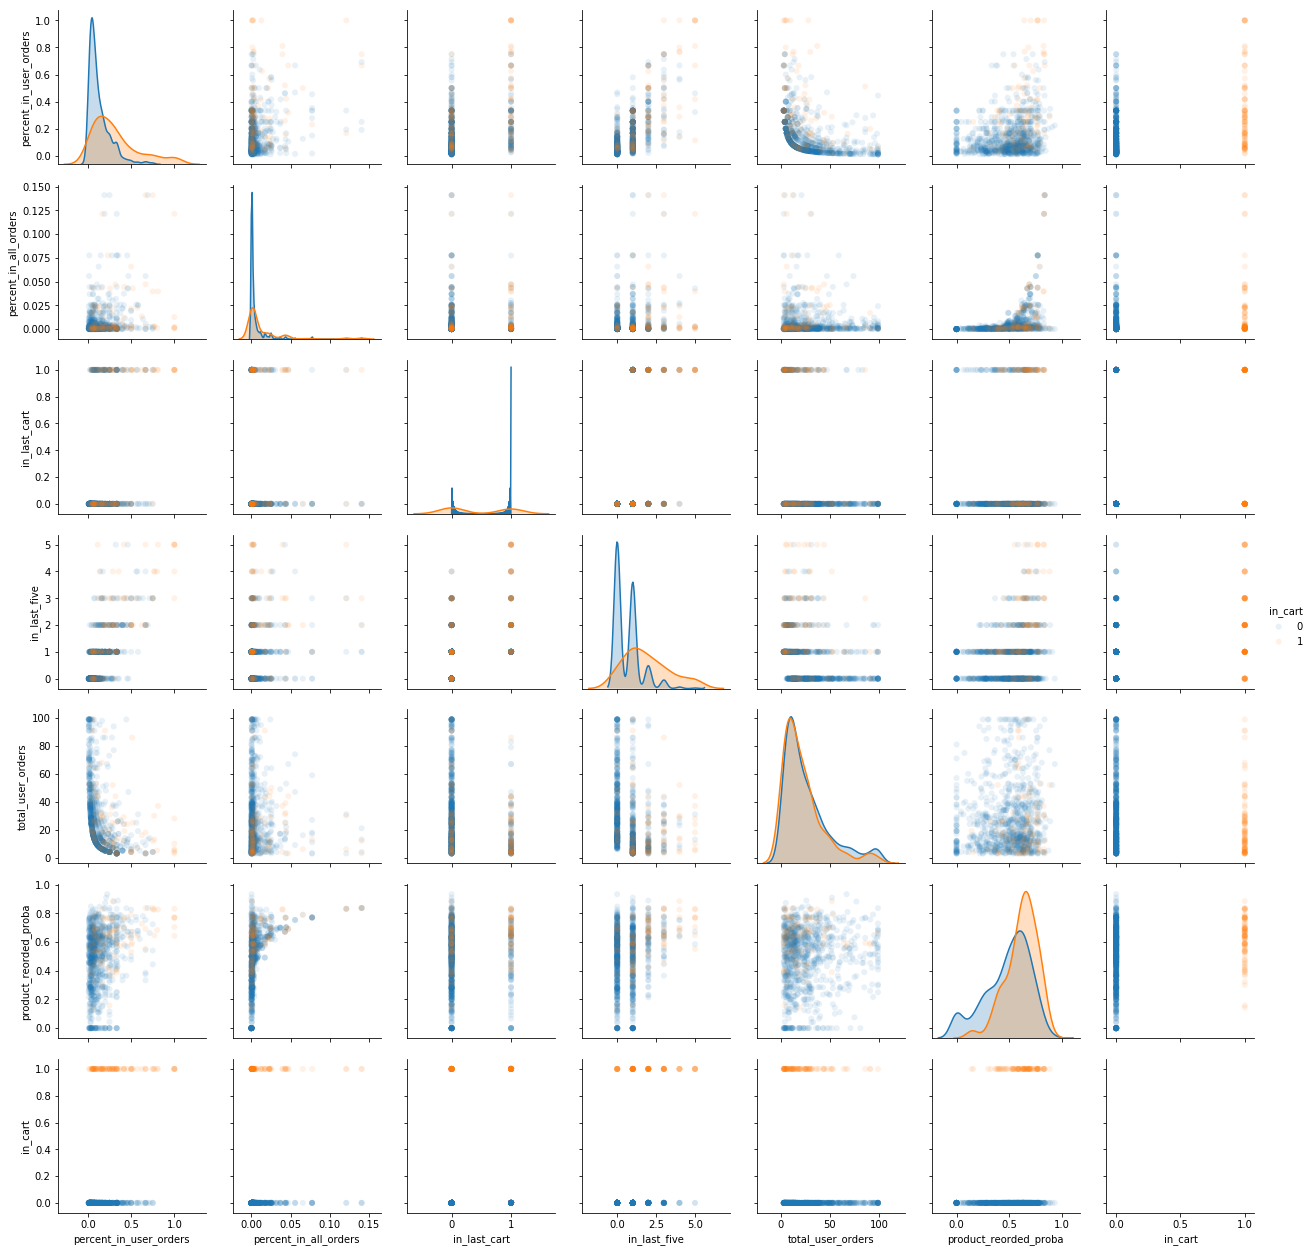

In [641]:
eda_df = pd.concat([X_train, y_train], axis=1).sample(1000)
sns.pairplot(eda_df, hue='in_cart', plot_kws=dict(alpha=.1, edgecolor='none'));

### Oversampling (Inactive)
Only significantly improved Logistic Regression
* Logistic = .23 to .35
* KNN = .24 to .29
* Random Forest = .24 to .27
* xgboost = .29 to .32

n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_neg, 0 : n_neg} 

ROS = imblearn.over_sampling.RandomOverSampler(ratio=ratio, random_state=29)    
X_train, y_train = ROS.fit_sample(X_train, y_train)

### Generic Threshold Adjustment Function

In [31]:
def adjust_threshold(model, X, threshold=.5):
    return (model.predict_proba(X)[:, 1] >= threshold).astype(int)

### Baseline Logistic Regression

In [119]:
def optimize_logistic_c(X_train, y_train, X_val, y_val):
    max_c = max_score = max_model = 0
    for c in range(-3, 6):
        c_val = 10 ** c
        model = LogisticRegression(C=c_val, solver='lbfgs', multi_class='auto', max_iter=200)
        model.fit(X_train, y_train)
        score = f1_score(y_val, model.predict(X_val))
        if score > max_score:
            max_c = c_val
            max_score = score
            max_model = model
            
    print(f'C = {max_c} yields the highest score: {max_score}')
    return max_model

In [120]:
lr = optimize_logistic_c(X_train, y_train, X_val, y_val)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

C = 10 yields the highest score: 0.28006628787878785


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [121]:
y_pred = lr.predict(X_val)
f1_score(y_val, y_pred), precision_score(y_val, y_pred), recall_score(y_val, y_pred)

(0.28006628787878785, 0.6051150895140665, 0.18219621130448174)

In [35]:
y_adj = adjust_threshold(lr, X_val, .15)
f1_score(y_val, y_adj), precision_score(y_val, y_adj), recall_score(y_val, y_adj)

(0.42703742784433, 0.35766271574131836, 0.5298013245033113)

var_to_pickle(y_val, 'temp/actual.pk')
var_to_pickle(y_adj, 'temp/lgr_pred.pk')

In [47]:
lr2 = LogisticRegression(C=10, penalty='l2', solver='lbfgs', max_iter=10000)
p = PolynomialFeatures(degree=2)
lr2.fit(p.fit_transform(X_train_scl), y_train)

y_pred = lr2.predict(p.transform(X_val_scl))
f1_score(y_val, y_pred), precision_score(y_val, y_pred), recall_score(y_val, y_pred)

(0.2832547169811321, 0.6044287871162557, 0.1849684275373479)

In [49]:
y_adj = adjust_threshold(lr2, p.transform(X_val_scl), .15)
f1_score(y_val, y_adj), precision_score(y_val, y_adj), recall_score(y_val, y_adj)

(0.4213471283783784, 0.3205365030921211, 0.6146619436316033)

### Baseline xgboost

In [50]:
gbm = xgb.XGBClassifier(n_estimators=30000,
                        max_depth=11,
                        objective="binary:logistic",
                        learning_rate=1, 
                        subsample=.001,
                        min_child_weight=1,
                        colsample_bytree=.8)

fit_model = gbm.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_val, y_val)],
                    eval_metric='auc',
                    early_stopping_rounds=20,
                    verbose=False);

In [51]:
y_pred = gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit)
f1_score(y_val, y_pred), precision_score(y_val, y_pred), recall_score(y_val, y_pred)

(0.2728920157765697, 0.44321329639889195, 0.19713537655937163)

In [52]:
y_adj = adjust_threshold(gbm, X_val, .23)
f1_score(y_val, y_adj), precision_score(y_val, y_adj), recall_score(y_val, y_adj)

(0.3700537529952723, 0.3192892266428252, 0.440012320961035)

var_to_pickle(y_adj, 'temp/xgb_pred.pk')

### Baseline SVC
*Tried SVC with various settings but can't get past the convergence warning*

svm_model = svm.SVC(kernel='poly', degree=3, probability=False, gamma='auto', C=1, max_iter=1000)
svm_model.fit(X_train_scl, y_train)

y_pred = svm_model.predict(X_val_scl)

### Baseline KNN Classifier

In [41]:
def optimize_knn(X_train, y_train, X_val, y_val, max_iter=20):
    max_k = max_score = max_model = 0
    for k in range(1, max_iter+1):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        score = f1_score(y_val, model.predict(X_val))
        if score > max_score:
            max_k = k
            max_score = score
            max_model = model
            
    print(f'k = {max_k} yields the highest score: {max_score}')
    return max_model

In [542]:
knn = optimize_knn(X_train, y_train, X_val, y_val)

k = 3 yields the highest score: 0.2850412249705536


In [543]:
y_pred = knn.predict(X_val)
f1_score(y_val, y_pred), precision_score(y_val, y_pred), recall_score(y_val, y_pred)

(0.2850412249705536, 0.39296346414073074, 0.2236254427845372)

In [544]:
y_adj = adjust_threshold(knn, X_val, .17)
f1_score(y_val, y_adj), precision_score(y_val, y_adj), recall_score(y_val, y_adj)

(0.31197459368578373, 0.22387559487901335, 0.5144001232096104)

var_to_pickle(y_adj, 'temp/knn_pred.pk')

### Baseline Random Forest Classifier

In [685]:
rf = RandomForestClassifier(n_estimators=10, n_jobs=-1)
rf.fit(X_train, y_train);

In [686]:
y_pred = rf.predict(X_val)
f1_score(y_val, y_pred), precision_score(y_val, y_pred), recall_score(y_val, y_pred)

(0.24579502130522538, 0.4519587628865979, 0.16879716617896195)

In [699]:
y_adj = adjust_threshold(rf, X_val, .28)
f1_score(y_val, y_adj), precision_score(y_val, y_adj), recall_score(y_val, y_adj)

(0.35188063413117815, 0.2950375312760634, 0.43585399661173574)

var_to_pickle(y_adj, 'temp/rfc_pred.pk')

### Group Common Products
* Brand name is often at the beginning
* Product name is often at the end
* Could look for words in common among products

### Merge Order and User Info

In [27]:
order_prods_df = order_prods_df.merge(products_df, how='left', on='product_id')
order_prods_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,department,aisle
0,1077,13176,1,1,Bag of Organic Bananas,produce,fresh fruits
1,1077,39922,2,1,Celery Sticks,produce,packaged vegetables fruits
2,1077,5258,3,1,Sparkling Water,beverages,water seltzer sparkling water
3,1077,21137,4,1,Organic Strawberries,produce,fresh fruits
4,1119,6046,1,1,Boneless Skinless Chicken Breast,meat seafood,poultry counter
